# Analyze & Prediction: Heart Disease

# Library Import

Importing library yang akan digunakan

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, classification_report

import pickle

In [5]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [6]:
df.columns = ['Age','Gender','ChestPain','RestingBloodPressure','Cholesterol','FastingBloodSugar','RestingECG','MaxHeartRateAchieved','ExerciseInducedAngina','Oldpeak','Slope','MajorVessels','Thalassemia','Target']
df.head()

,Age,Gender,ChestPain,RestingBloodPressure,Cholesterol,FastingBloodSugar,RestingECG,MaxHeartRateAchieved,ExerciseInducedAngina,Oldpeak,Slope,MajorVessels,Thalassemia,Target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [7]:
df['Thalassemia'].value_counts()

2    544
3    410
1     64
0      7
Name: Thalassemia, dtype: int64

Dikarenakan di dalam deskipsi pada dataset kolom Thalassemia seharusnya hanya ada 3 value saja; 0, 1 dan 2, maka value 0 dan 1 yang ada di dalam dataset akan dijadikan satu value.

In [8]:
thala = []
for i in df['Thalassemia']:
    if i == 0: 
        thala.append(0)
    elif i == 1:
        thala.append(0)
    elif i == 2:
        thala.append(1)
    elif i == 3:
        thala.append(2)

df['Thalassemia'] = pd.Series(thala)

In [9]:
df['Thalassemia'].value_counts()

1    544
2    410
0     71
Name: Thalassemia, dtype: int64

# Dataset Description  

Deskripsi dari kolom-kolom yang ada pada dataset  

## Gender
2 type:  
- 0 = male
- 1 = female

## Chest Pain
4 type:  
- 0 = typical angina: Diantaranya (1) nyeri dada bagian bawah atau ketidaknyamanan, yang biasanya dipicu oleh (2) aktivitas atau stres emosional, (3) dan dapat disembuhkan dengan istirahat atau menggunakan nitrogliserin/obat gagal jantung/tekanan darah tinggi/nyeri dada
- 1 = atypical angina: Terjadi jika terdapat 2 dari 3 kriteria typical angina/angina klasik
- 2 = non-anginal pain: Atau sering dibilang dengan non-cardiac chest pain, adalah nyeri dada yang menyerupai penyakit jantung di pasien yang tidak mempunyai riwayat penyakit jantung
- 3 = asymptomatic: Tidak menunjukan symptoms/gejala  

## Resting Blood Pressure:
Tekanan darah saat istirahat  
Normalnya, tekanan darah pada orang dewasa sekitar 120mm/Hg(millimeters of mercury).  

## Cholesterol:
Adalah zat seperti lilin dan lemak yang dapat ditemukan di semua sel di dalam tubuh. Kolesterol dibutuhkan untuk membuat hormon, vitamin D, dan membantu untuk mencerna makanan.  

## Fasting Blood Sugar:
Tes untuk mengambil sempel darah setelah pasien melakukan puasa satu malam.  
2 type:
- 0 = false, artinya gula darah < 120mg/dl
- 1 = true, artinya gula darah > 120mg/dl

## Resting ECG:
ECG atau electrocardiogram adalah alat untuk merekam sinyal listrik di jantung.  
3 type:
- 0 = normal
- 1 = memiliki kelainan gelombang ST-T
- 2 = menunjukan kemungkinan atau pasti 'left ventricular hypertrophy' atau penyempitan dinding ruang pompa utama jantung menurut kriteria Estes  
<img src= './Image/ST-T.png' width=500 height=300>

## Max Heart Rate Achieved:
detak jantung paling tinggi

## Exercise Induced angina:
apakah olahraga menyebabkan angina/nyeri dada
2 type:
- 0 = false
- 1 = true

## Old peak:
Gelombang dari alat ECG, untuk melihat apakah ada ST depression yang disebabkan oleh olahraga  
<img src= './Image/ST-depression.png' width=500 height=300>

## Slope:
Untuk melihat type ST depression (mengacu pada kolom sebelumnya)  
3 type:
- 0 = upsloping
- 1 = horizontal/flat
- 2 = downsloping

## Major Vessels:
Jumlah pembuluh darah utama yang ditandai oleh Fluoroscopy (teknik pencitraan yang menggunakan X-ray untuk mendapatkan gambar bergerak secara real-time dari bagian suatu objek). Superior vena cava, Inferior vena cava, Pulmonary artery, Pulmonary vein, Aorta.    

## Thalassemia:
adalah kelainan darah bawaan yang menyebabkan tubuh memiliki hemoglobin lebih sedikit dari biasanya  
4 type:
- 0 = normal
- 1 = fixed defect, cacat tetap
- 2 = reversable defect, cacat yang dapat disembuhkan 

## Target:
2 type:
- 0 = no desease
- 1 = disease

---

# Exploratory Data Analysis

## Missing Value

In [10]:
df.isna().sum()

Age                      0
Gender                   0
ChestPain                0
RestingBloodPressure     0
Cholesterol              0
FastingBloodSugar        0
RestingECG               0
MaxHeartRateAchieved     0
ExerciseInducedAngina    0
Oldpeak                  0
Slope                    0
MajorVessels             0
Thalassemia              0
Target                   0
dtype: int64

Tidak ditemukan missing value

## Outlier

Pengecekan outlier dilakukan pada data yang bersifat numerical/continous

In [11]:
def find_anomalies(data):
    anomalies = []
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    batas = IQR * 1.5

    lower_limit = Q1 - batas
    upper_limit = Q3 + batas

    for outlier in data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies

In [12]:
def outlier(data):
    column_name = []
    outlier = []
    percentage = []

    for j in ['Age','RestingBloodPressure','Cholesterol','FastingBloodSugar','MaxHeartRateAchieved','Oldpeak','MajorVessels']: 
        column_name.append(j)
        outlier.append(len(find_anomalies(df[j]))) 
        percentage.append(round(len(find_anomalies(df[j]))/df.shape[0]*100, 2)) 
    
    return pd.DataFrame({ 
        'Column':column_name,
        'Outlier':outlier,
        'Percentage':percentage
        })

In [13]:
outlier(df) 

,Column,Outlier,Percentage
0,Age,0,0.00
1,RestingBloodPressure,30,2.93
2,Cholesterol,16,1.56
3,FastingBloodSugar,153,14.93
4,MaxHeartRateAchieved,4,0.39
5,Oldpeak,7,0.68
6,MajorVessels,87,8.49


Outlier pada data set Heart Disease dianggap tidak banyak dan tidak mengganggu dikarenakan persentasi outlier terhadap data paling banyak pada kolom FastingBloodSugar sebesar 14.93%

## Statistic Descriptive  


Untuk melihat deskripsi statistik, dibedakan menjadi 2 yaitu untuk pasien yang tidak mempunyai penyakit jantung dan pasien yang mempunyai penyakit jantung. Deskripsi statistik ini dilakukan untuk mengetahui dan mengenal dataset

In [14]:
df[df['Target']==0].describe() 

,Age,Gender,ChestPain,RestingBloodPressure,Cholesterol,FastingBloodSugar,RestingECG,MaxHeartRateAchieved,ExerciseInducedAngina,Oldpeak,Slope,MajorVessels,Thalassemia,Target
count,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.0
mean,56.569138,0.827655,0.482966,134.106212,251.292585,0.164329,0.456914,139.130261,0.549098,1.600200,1.166333,1.158317,1.547094,0.0
std,7.908153,0.378059,0.908024,18.576736,49.558924,0.370945,0.544825,22.565235,0.498083,1.290956,0.568932,1.032108,0.661086,0.0
min,35.000000,0.000000,0.000000,100.000000,131.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,52.000000,1.000000,0.000000,120.000000,217.000000,0.000000,0.000000,125.000000,0.000000,0.600000,1.000000,0.000000,1.000000,0.0
50%,58.000000,1.000000,0.000000,130.000000,249.000000,0.000000,0.000000,142.000000,1.000000,1.400000,1.000000,1.000000,2.000000,0.0
75%,62.000000,1.000000,0.000000,144.000000,284.000000,0.000000,1.000000,156.000000,1.000000,2.500000,2.000000,2.000000,2.000000,0.0
max,77.000000,1.000000,3.000000,200.000000,409.000000,1.000000,2.000000,195.000000,1.000000,6.200000,2.000000,4.000000,2.000000,0.0


In [15]:
df[df['Target']==1].describe() 

,Age,Gender,ChestPain,RestingBloodPressure,Cholesterol,FastingBloodSugar,RestingECG,MaxHeartRateAchieved,ExerciseInducedAngina,Oldpeak,Slope,MajorVessels,Thalassemia,Target
count,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.0
mean,52.408745,0.570342,1.378327,129.245247,240.979087,0.134981,0.598859,158.585551,0.134981,0.569962,1.593156,0.370722,1.125475,1.0
std,9.631804,0.495498,0.945881,16.112188,53.010345,0.342029,0.502109,19.096928,0.342029,0.771079,0.590295,0.871462,0.448741,0.0
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,44.000000,0.000000,1.000000,120.000000,208.000000,0.000000,0.000000,149.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.0
50%,52.000000,1.000000,2.000000,130.000000,234.000000,0.000000,1.000000,161.500000,0.000000,0.200000,2.000000,0.000000,1.000000,1.0
75%,59.000000,1.000000,2.000000,140.000000,265.750000,0.000000,1.000000,172.000000,0.000000,1.000000,2.000000,0.000000,1.000000,1.0
max,76.000000,1.000000,3.000000,180.000000,564.000000,1.000000,2.000000,202.000000,1.000000,4.200000,2.000000,4.000000,2.000000,1.0


## Correlation

Untuk mengecek korelasi antar kolom, maka kolom yang dipakai adalah kolom berjenis numerical/continous, yaitu:

- Age
- RestingBloodPressure
- Cholesterol
- FastingBloodSugar
- MaxHeartRateAchieved
- Oldpeak
- MajorVessels

> ## Mengecek Distribusi

In [16]:
def distribusi(): 
    list_kolom = []
    list_distribusi = [] 
    for i in ['Age','RestingBloodPressure','Cholesterol','FastingBloodSugar','MaxHeartRateAchieved','Oldpeak','MajorVessels']: 
        alpha = 0.05 
        stat, p = stats.normaltest(df[i]) 
        list_kolom.append(i) 
        if p < alpha: 
            list_distribusi.append('Tidak Normal')
        else: 
            list_distribusi.append('Normal') 
    return pd.DataFrame({
        'Kolom':list_kolom,
        'Distribusi':list_distribusi
    })

In [17]:
distribusi() # memanggil fungsi

,Kolom,Distribusi
0,Age,Tidak Normal
1,RestingBloodPressure,Tidak Normal
2,Cholesterol,Tidak Normal
3,FastingBloodSugar,Tidak Normal
4,MaxHeartRateAchieved,Tidak Normal
5,Oldpeak,Tidak Normal
6,MajorVessels,Tidak Normal


Semua kolom pada data set berdistribusi tidak normal, karena nilai p < alpha (0.05) maka reject H0

> ## Mengecek Korelasi

Dikarenakan pada setiap kolom memiliki distribusi tidak normal, maka metode korelasi yang digunakan adalah Spearman

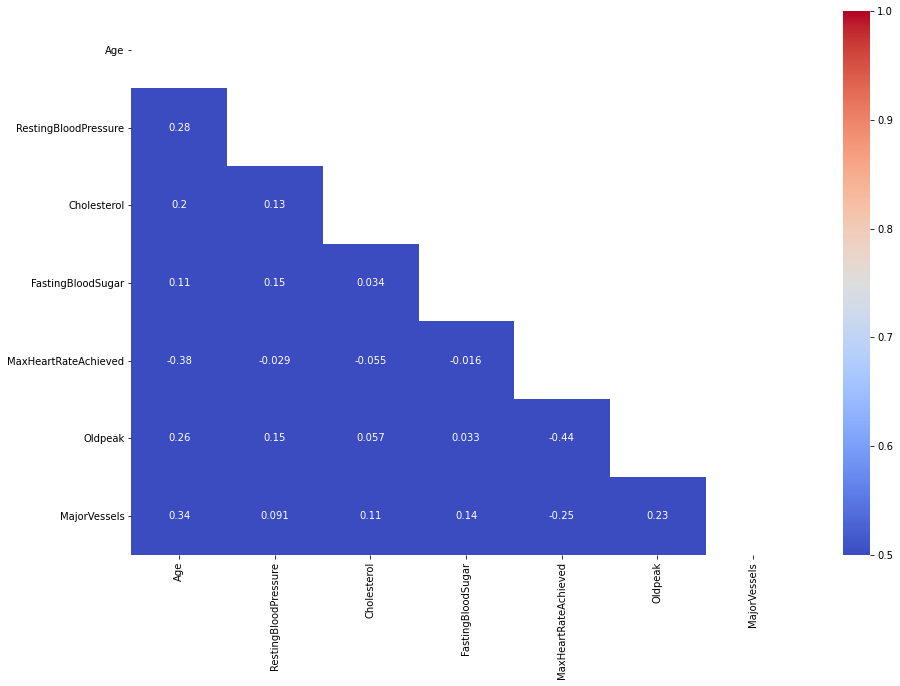

In [18]:
mask = np.zeros_like(df[['Age','RestingBloodPressure','Cholesterol','FastingBloodSugar','MaxHeartRateAchieved','Oldpeak','MajorVessels']].corr())
mask[np.triu_indices_from(mask)]=True

plt.figure(figsize=(15,10))
sns.heatmap(df[['Age','RestingBloodPressure','Cholesterol','FastingBloodSugar','MaxHeartRateAchieved','Oldpeak','MajorVessels']].corr(method='spearman'), cmap='coolwarm', annot=True, mask=mask, vmin=0.5, vmax=1)
plt.show()

<img src= './Image/coef correlation.png' width=300 height=150> 

Hinkle DE, Wiersma W, Jurs SG. *Applied Statistics for the Behavioral Sciences*. 5th ed. Boston: Houghton Mifflin; 2003  

Mengacu pada koefisien korelasi pada buku *Applied Statistics for the Behavioral Sciences*, heatmap di atas menunjukan bahwa umur mempunyai korelasi yang rendah terhadap jumlah pembuluh darah utama yang ditandai oleh Fluoroscopy. Sedangkan untuk kolom yang lain tidak memiliki korelasi hingga korelasi yang negatif

## Plotting

In [19]:
df_temp = df.copy()

> ## Age

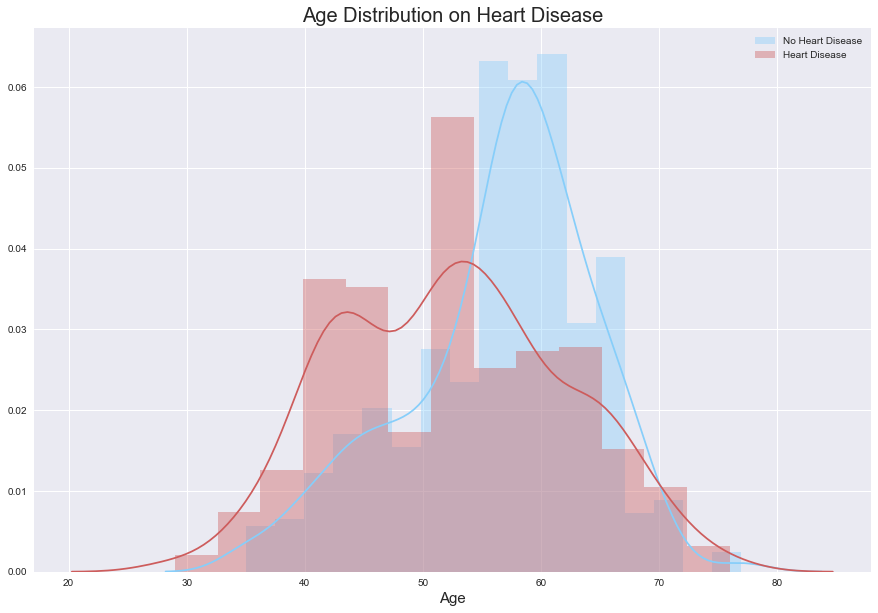

In [20]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn')
sns.distplot(df_temp[df_temp['Target']==0]['Age'], color='lightskyblue')
sns.distplot(df_temp[df_temp['Target']==1]['Age'], color='indianred')
plt.xlabel('Age', fontsize=15)
plt.legend(['No Heart Disease','Heart Disease'])
plt.title('Age Distribution on Heart Disease', fontsize=20)
plt.show()

- Distribusi umur pada pasien yang mengalami penyakit jantung berada pada rentang umur 20 hingga 80, namun paling banyak berada pada sekitar umur 54
- Distribusi umur pada pasien yang tidak mengalami penyakit jantung berada pada rentang umur 30 hingga 80, namun paling banyak berada pada sekitar umur 55 hingga 62

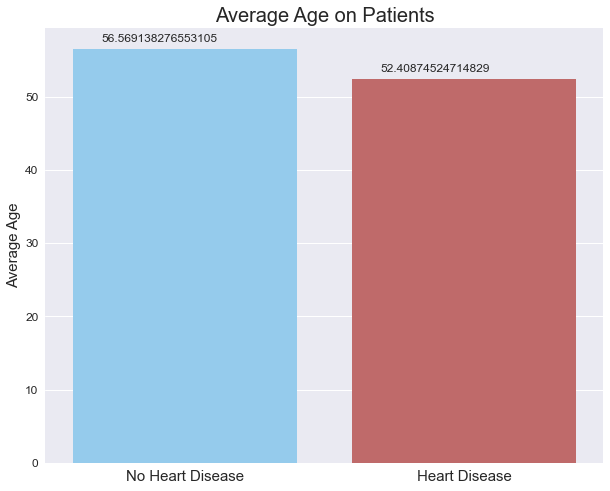

In [21]:
df_group = df_temp.groupby('Target', as_index=False).mean()

plt.figure(figsize=(10,8))
plt.style.use('seaborn')
fig = sns.barplot(x=df_temp['Target'].unique(), y=df_group['Age'], palette=['lightskyblue','indianred'])
label = ['No Heart Disease', 'Heart Disease']
plt.ylabel('Average Age', fontsize=15)
plt.xticks(np.arange(2), labels=label, fontsize=15)
plt.yticks(fontsize=12)
plt.title('Average Age on Patients', fontsize=20)

for p in fig.patches:
    fig.annotate(p.get_height(), (p.get_x()+0.10, p.get_height()+1), fontsize=12)

plt.show()

- Rata-rata umur pasien yang mengalami penyakit jantung lebih rendah, yaitu 52
- Rata-rata umur pasien yang tidak mengalami penyakit jantung lebih tinggi, yaitu 55

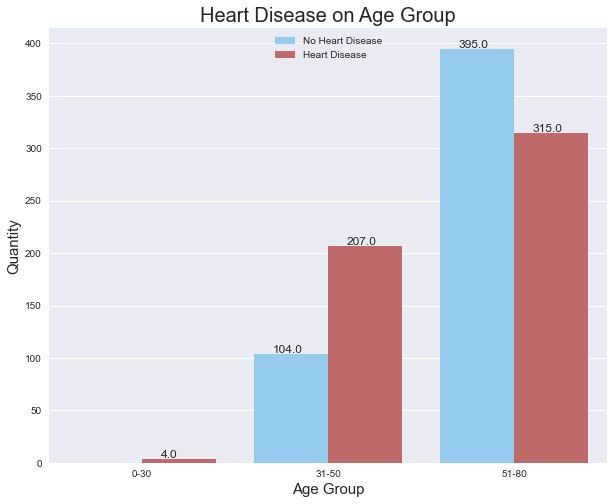

In [22]:
df_temp['Age_group'] = pd.cut(df_temp['Age'], (0,30,50,80), labels=['0-30','31-50','51-80'])

plt.figure(figsize=(10,8))
fig = sns.countplot(x='Age_group', hue='Target', data=df_temp, palette=['lightskyblue','indianred'])
plt.legend(['No Heart Disease','Heart Disease'])
plt.xlabel('Age Group', fontsize=15)
plt.ylabel('Quantity', fontsize=15)
plt.title('Heart Disease on Age Group', fontsize=20)

for p in fig.patches:
    fig.annotate(p.get_height(), (p.get_x()+0.10, p.get_height()+1), fontsize=12)

plt.show()

In [23]:
percentage_age = round(len(df_temp[(df_temp['Age_group']=='31-50') & (df_temp['Target']==1)]) / len(df_temp[(df_temp['Age_group']=='31-50') & (df_temp['Target']==0)])*100) 
kali_lipat = percentage_age/100 

print(percentage_age)
print(kali_lipat)

199
1.99


- Pasien yang mempunyai penyakit jantung terbanyak pada rentang umur 51-80
- Perbedaan pasien yang mempunyai penyakit jantung dengan pasien yang tidak mempunyai penyakit jantung pada rentang umur 31-50 sebesar 199% atau 1.99 kali lipat

> ## Chestpain

4 type:  
- 0 = typical angina: (1) Nyeri dada bagian bawah atau ketidaknyamanan, yang biasanya dipicu oleh (2) aktivitas atau stres emosional, (3) dan dapat disembuhkan dengan istirahat atau (4) menggunakan nitrogliserin/obat gagal jantung/tekanan darah tinggi/nyeri dada
- 1 = atypical angina: Terjadi jika terdapat 2 atau 3 kriteria typical angina/angina klasik
- 2 = non-anginal pain: Atau sering dibilang dengan non-cardiac chest pain, adalah nyeri dada yang menyerupai penyakit jantung di pasien yang tidak mempunyai riwayat penyakit jantung
- 3 = asymptomatic: Tidak menunjukan symptoms/gejala  

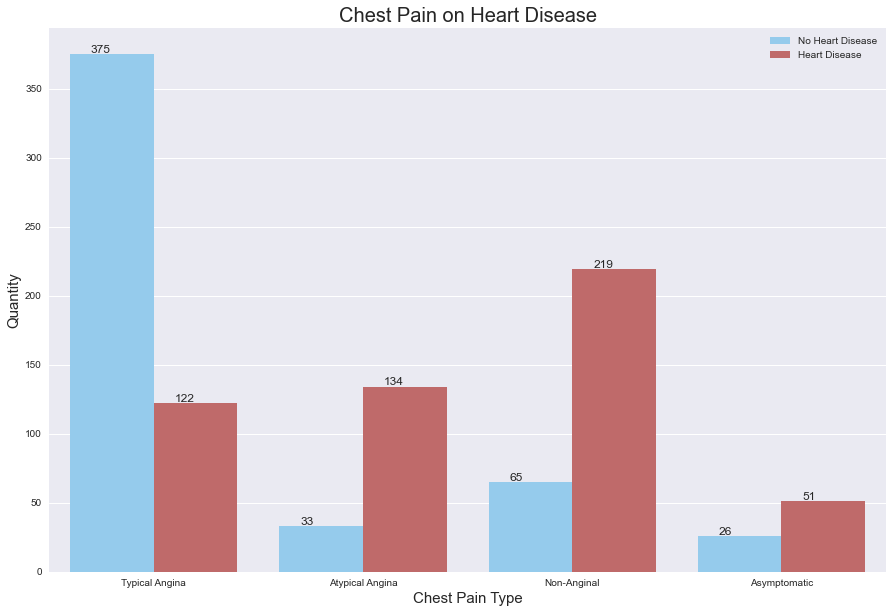

In [24]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn')
fig = sns.countplot(x='ChestPain', hue='Target', data=df_temp, palette=['lightskyblue','indianred'])
label = ['Typical Angina','Atypical Angina','Non-Anginal','Asymptomatic']
plt.xticks(np.arange(4),labels=label)
plt.title('Chest Pain on Heart Disease', fontsize=20)
plt.xlabel('Chest Pain Type', fontsize=15)
plt.ylabel('Quantity', fontsize=15)
plt.legend(['No Heart Disease','Heart Disease'])

for p in fig.patches:
    fig.annotate(p.get_height(), (p.get_x()+0.10, p.get_height()+1), fontsize=12)
    
plt.show()

In [25]:
percentage_asympto = len(df_temp[(df_temp['ChestPain']==3) & (df_temp['Target']==1)]) / len(df_temp[(df_temp['ChestPain']==3) & (df_temp['Target']==0)])*100 
percentage_non = len(df_temp[(df_temp['ChestPain']==2) & (df_temp['Target']==1)]) / len(df_temp[(df_temp['ChestPain']==2) & (df_temp['Target']==0)])*100
percentage_atypical = len(df_temp[(df_temp['ChestPain']==1) & (df_temp['Target']==1)]) / len(df_temp[(df_temp['ChestPain']==1) & (df_temp['Target']==0)])*100
percentage_list = [percentage_asympto, percentage_non, percentage_atypical]

for i in percentage_list:
    print('Percentage',i)
    print('kali lipat',i/100)

Percentage 196.15384615384613
kali lipat 1.9615384615384612
Percentage 336.9230769230769
kali lipat 3.3692307692307693
Percentage 406.06060606060606
kali lipat 4.0606060606060606


- Perbedaan terbesar antara pasien berpenyakit jantung dengan pasien tidak berpenyakit jantung paling besar, hingga 4 kali lipat, terdapat pada tipe nyeri dada atypical angina atau nyeri dada yang terjadi jika terdapat 2 atau 3 kriteria nyeri dada typical angina/nyeri dada klasik: (1) Nyeri dada bagian bawah atau ketidaknyamanan, yang biasanya dipicu oleh (2) aktivitas atau stres emosional, (3) dan dapat disembuhkan dengan istirahat atau (4) menggunakan nitrogliserin/obat gagal jantung/tekanan darah tinggi/nyeri dada)
- Walaupun asymptomatic/tidak menunjukan gejala, seorang pasien mempunyai kemungkinan untuk terkena penyakit jantung
- Jumlah pasien yang mempunyai penyakit jantung terbanyak berdasarkan tipe nyeri dada terbanyak ada di non-anginal atau nyeri dada yang menyerupai penyakit jantung, yang artinya walaupun pasien tersebut tidak pernah mempunyai riwayat penyakit jantung sebelumnya, ada kemungkinan seorang pasien terkena penyakit jantung

**exercise Induce Angina**  

apakah olahraga menyebabkan angina/nyeri dada  
2 type:
- 0 = false
- 1 = true

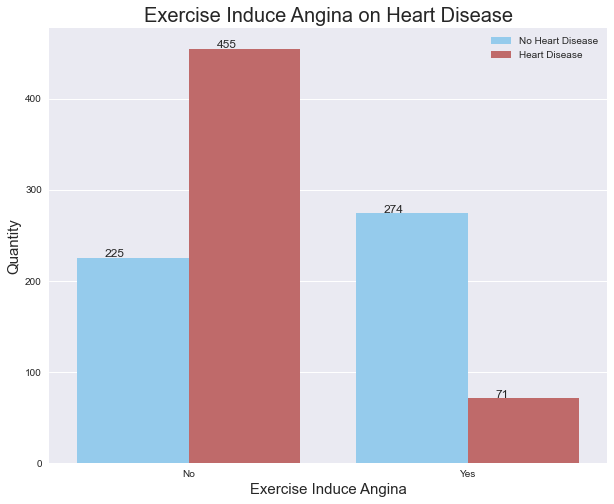

In [26]:
plt.figure(figsize=(10,8))
fig = sns.countplot(x='ExerciseInducedAngina', hue='Target', data=df_temp, palette=['lightskyblue','indianred']) 
plt.legend(['No Heart Disease','Heart Disease'])
plt.xticks(np.arange(2), labels=['No','Yes'])
plt.xlabel('Exercise Induce Angina', fontsize=15)
plt.ylabel('Quantity', fontsize=15)
plt.title('Exercise Induce Angina on Heart Disease', fontsize=20)

for p in fig.patches:
    fig.annotate(p.get_height(), (p.get_x()+0.10, p.get_height()+1), fontsize=12)
    
plt.show()

- Pada pasien yang mempunyai penyakit jantung, kebanyakan pasien tidak merasakan nyeri dada setelah olahraga
- Pasien dengan nyeri dada setelah olahraga, belum tentu mempunyai penyakit jantung

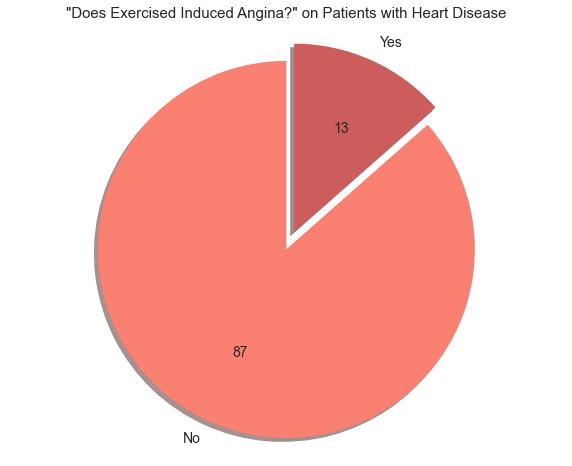

In [27]:
df_target_1 = df_temp[df_temp['Target']==1].groupby('ExerciseInducedAngina', as_index=False).count()

plt.figure(figsize=(10,8))
plt.style.use('seaborn')
plt.pie(df_target_1['Target'], labels=['No','Yes'], autopct='%.f', explode=(0, 0.1), shadow=True, startangle=90, colors=['Salmon','indianred'], textprops={'fontsize':14})
plt.axis('equal')
plt.title('"Does Exercised Induced Angina?" on Patients with Heart Disease', fontsize=15)
plt.show()

- Sebanyak 87% dari pasien yang mempunyai penyakit jantung tidak merasakan nyeri dada setelah olahraga

> ## Cholesterol

Adalah zat seperti lilin dan lemak yang dapat ditemukan di semua sel di dalam tubuh. Kolesterol dibutuhkan untuk membuat hormon, vitamin D, dan membantu untuk mencerna makanan.  
5 type cholesterol:
- <100 = optimum
- 100 - 129 = cukup baik
- 130 - 159 = batas tinggi
- 160 - 189 = tinggi
- =>190 = sangat tinggi

*dalam satuan mg/dl*

In [28]:
series = [] 
for i in df['Cholesterol']: 
    if i < 100:
        series.append('optimum') 
    elif i >= 100 and i < 130:
        series.append('fairly good') 
    elif i >= 130 and i < 160:
        series.append('borderline high') 
    elif i >= 160 and i < 190:
        series.append('high') 
    else:
        series.append('very high') 

df_temp['CholesterolLabel'] = pd.Series(series) 

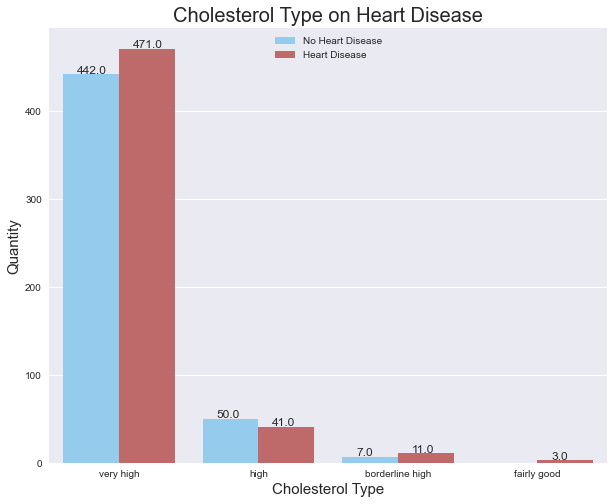

In [29]:
plt.figure(figsize=(10,8))
plt.style.use('seaborn')
fig = sns.countplot(x='CholesterolLabel', hue='Target', data=df_temp, palette=['lightskyblue','indianred'])
plt.legend(['No Heart Disease','Heart Disease'])
plt.xlabel('Cholesterol Type', fontsize=15)
plt.ylabel('Quantity', fontsize=15)
plt.title('Cholesterol Type on Heart Disease', fontsize=20)

for p in fig.patches:
    fig.annotate(p.get_height(), (p.get_x()+0.10, p.get_height()+1), fontsize=12)

plt.show()

- Pasien yang mempunyai penyakit jantung maupun yang tidak, kebanyakan memiliki kolesterol yang sangat tinggi, yakni diatas 190mg/dl (miligram per deciliter)
- Pasien yang memiliki kolesterol yang sangat tinggi lebih banyak yang berpenyakit jantung
- Walaupun memiliki tingkat kolesterol yang optimum/fairly good, tidak menutup kemungkinan mempunyai penyakit jantung

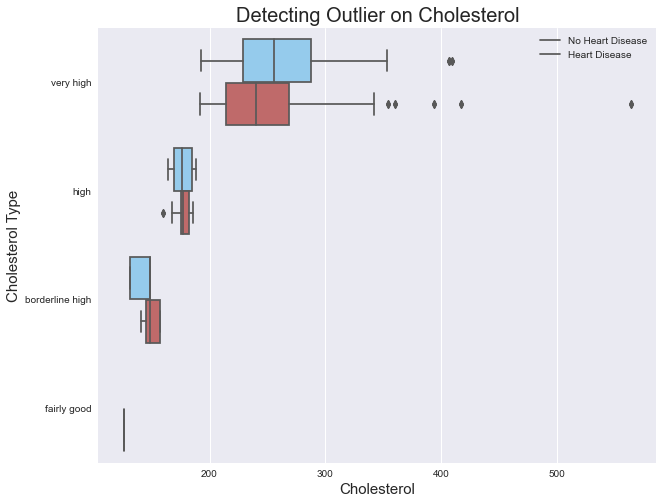

In [30]:
plt.figure(figsize=(10,8))
sns.boxplot(x='Cholesterol', y='CholesterolLabel', hue='Target', data=df_temp, palette=['lightskyblue','indianred'])
plt.legend(['No Heart Disease','Heart Disease'])
plt.xlabel('Cholesterol', fontsize=15)
plt.ylabel('Cholesterol Type', fontsize=15)
plt.title('Detecting Outlier on Cholesterol', fontsize=20)
plt.show()

- Dalam pasien yang mempunyai penyakit jantung, pada golongan pasien bertipe kolesterol sangat tinggi dengan batas bawah 190 dan batas atas sekitar 330, namun terdapat pasien yang mempunyai kolesterol sangat tinggi yakni sekitar 560 dan kemungkinan pasien tersebut adalah pasien yang obesitas

> ## Resting Blood Pressure

Tekanan darah saat istirahat  

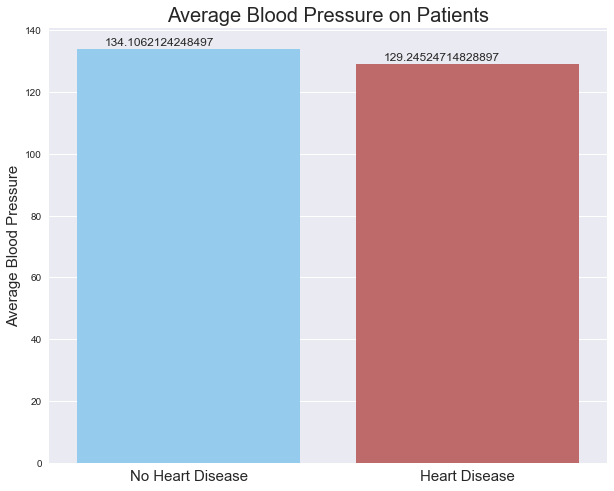

In [31]:
plt.figure(figsize=(10,8))
fig = sns.barplot(x=df_temp['Target'].unique(), y=df_group['RestingBloodPressure'], palette=['lightskyblue','indianred'])
label = ['No Heart Disease','Heart Disease']
plt.xticks(np.arange(2), labels=label, fontsize=15)
plt.ylabel('Average Blood Pressure', fontsize=15)
plt.title('Average Blood Pressure on Patients', fontsize=20)

for p in fig.patches:
    fig.annotate(p.get_height(), (p.get_x()+0.10, p.get_height()+1), fontsize=12)
    
plt.show()

- Rata-rata tekanan darah pada pasien yang mempunyai penyakit jantung lebih rendah yaitu 129.2 dan yang tidak mempunyai penyakit jantung lebih tinggi yaitu 134.1

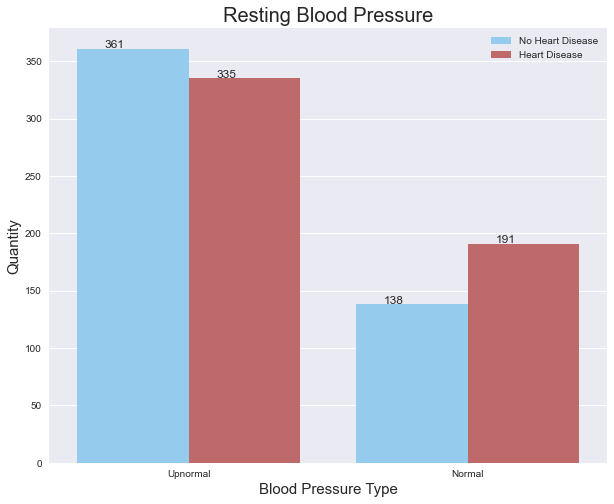

In [32]:
df_temp['BloodPressureLabel'] = np.where(df['RestingBloodPressure']>120,'Upnormal','Normal')

plt.figure(figsize=(10,8))
plt.style.use('seaborn')
fig = sns.countplot(x='BloodPressureLabel', hue='Target', data=df_temp, palette=['lightskyblue','indianred'])
plt.xlabel('Blood Pressure Type', fontsize=15)
plt.ylabel('Quantity', fontsize=15)
plt.legend(['No Heart Disease','Heart Disease'])
plt.title('Resting Blood Pressure', fontsize=20)

for p in fig.patches:
    fig.annotate(p.get_height(), (p.get_x()+0.10, p.get_height()+1), fontsize=12)
    
plt.show()

Normalnya, tekanan darah pada orang dewasa sekitar 120mm/Hg(millimeters of mercury), maka akan dibagi menjadi 2 golongan yakni:  
1. Upnormal, dengan tekanan darah diatas 120mm/Hg (millimeters of mercury)  
2. Normal, dengan tekanan darah dibawah 120mm/Hg (millimeters of mercury)

Didapatkan bahwa:
- Jumlah pasien dengan tekanan darah upnormal lebih banyak yang tidak mempunyai penyakit jantung
- Jumlah pasien dengan tekanan darah normal lebih banyak yang mempunyai penyakit jantung
- Jumlah pasien yang mempunyai penyakit jantung lebih banyak bertekanan darah upnormal

> ## Cholesterol & Resting Blood Pressure

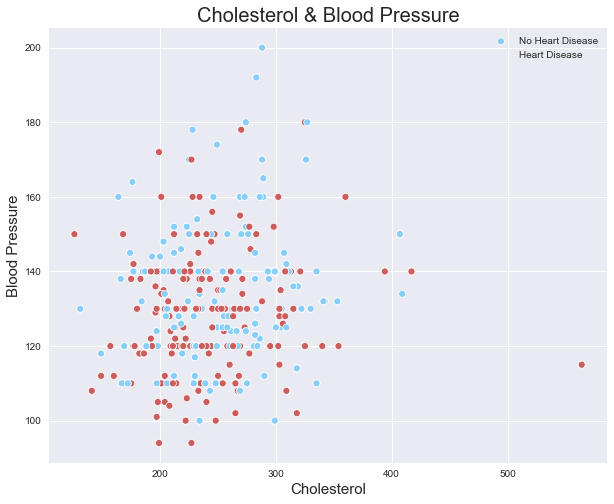

In [33]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='Cholesterol', y='RestingBloodPressure', hue='Target', data=df_temp, palette=['lightskyblue','indianred'])
plt.legend(['No Heart Disease','Heart Disease'])
plt.xlabel('Cholesterol', fontsize=15)
plt.ylabel('Blood Pressure', fontsize=15)
plt.title('Cholesterol & Blood Pressure', fontsize=20)
plt.show()

- Salah satu pasien yang memiliki kolesterol tinggi mempunyai penyakit jantung, walaupun bertekanan darah normal (<120mm/Hg)
- Pasien yang mempunyai penyakit jantung tersebar tidak terarah, yang artinya pasien bisa saja mempunyai penyakit jantung walaupun pasien tersebut mempunyai kolesterol yang rendah dan tekanan darah yang normal

> ## Fasting Blood Sugar

Tes untuk mengambil sempel darah setelah pasien melakukan puasa satu malam.  
2 type:
- 0 = false, artinya gula darah < 120mg/dl
- 1 = true, artinya gula darah > 120mg/dl

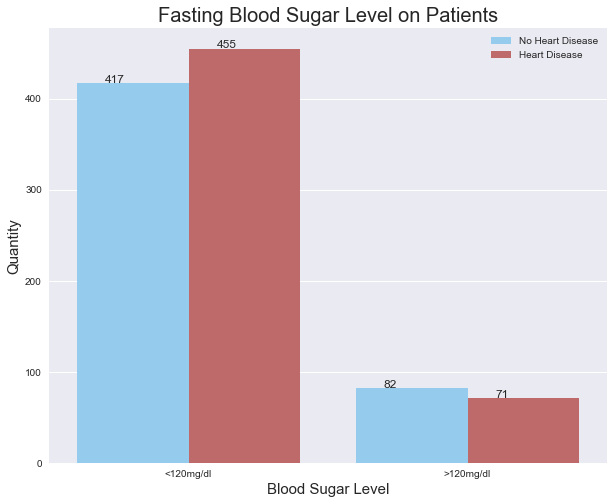

In [34]:
plt.figure(figsize=(10,8))
fig = sns.countplot(x='FastingBloodSugar', hue='Target', data=df_temp, palette=['lightskyblue','indianred'])
plt.legend(['No Heart Disease','Heart Disease'])
label = ['<120mg/dl','>120mg/dl']
plt.xticks(np.arange(2), labels=label)
plt.xlabel('Blood Sugar Level', fontsize=15)
plt.ylabel('Quantity', fontsize=15)
plt.title('Fasting Blood Sugar Level on Patients', fontsize=20)

for p in fig.patches:
    fig.annotate(p.get_height(), (p.get_x()+0.10, p.get_height()+1), fontsize=12)

plt.show()

- Jumlah pasien yang bergula darah rendah atau di bawah 120mg/dl (milligram per deciliter) yang mempunyai penyakit jantung lebih banyak, yakni 455 pasien, dibandingkan dengan pasien tidak mempunyai penyakit jantung, yakni 417 pasien
- Jumlah pasien yang memiliki penyakit jantung dan bergula darah rendah lebih tinggi dibandingkan jumlah pasien yang memiliki penyakit jantung dan bergula darah tinggi

> ## Max Heart Rate

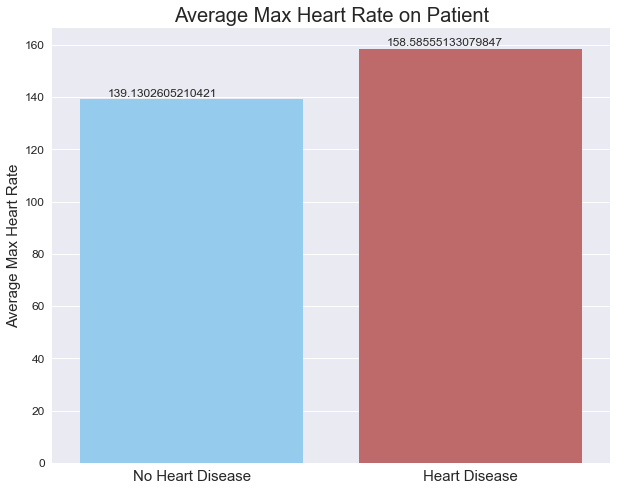

In [35]:
plt.figure(figsize=(10,8))
fig = sns.barplot(x=df['Target'].unique(), y=df_group['MaxHeartRateAchieved'], palette=['lightskyblue','indianred'])
label = ['No Heart Disease', 'Heart Disease']
plt.ylabel('Average Max Heart Rate', fontsize=15)
plt.xticks(np.arange(2), labels=label, fontsize=15)
plt.yticks(fontsize=12)
plt.title('Average Max Heart Rate on Patient', fontsize=20)

for p in fig.patches:
    fig.annotate(p.get_height(), (p.get_x()+0.10, p.get_height()+1), fontsize=12)
    
plt.show()

- Rata-rata maksimum detak jantung pasien yang mempunyai penyakit jantung lebih tinggi, yakni 158.5

> ## Max Heart Rate & Resting Blood Pressure

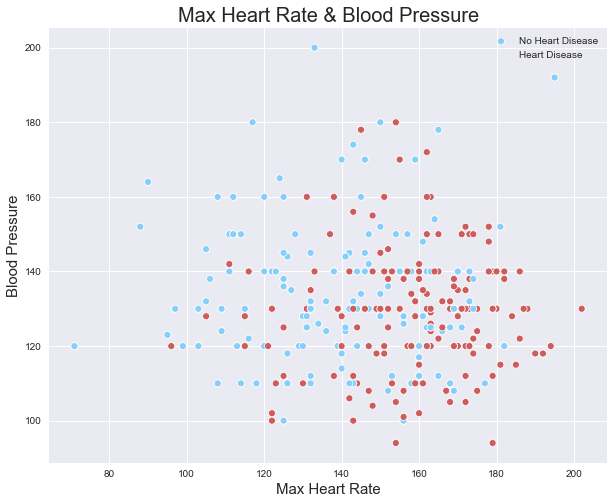

In [36]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='MaxHeartRateAchieved', y='RestingBloodPressure', hue='Target', data=df_temp, palette=['lightskyblue','indianred'])
plt.legend(['No Heart Disease','Heart Disease'])
plt.xlabel('Max Heart Rate', fontsize=15)
plt.ylabel('Blood Pressure', fontsize=15)
plt.title('Max Heart Rate & Blood Pressure', fontsize=20)
plt.show()

In [37]:
df_temp['MaxHeartRateAchieved'].mean() 

149.11414634146342

- Terdapat pasien bertekanan darah dan maksimum detak jantung yang tinggi, namun tidak mempunyai penyakit jantung
- Terdapat pasien bertekanan darah rendah dengan maksimum detak jantung di rata-rata (149), akan tetapi pasien tersebut mempunyai penyakit jantung
- Dari plot di atas dapat dilihat pola persebarannya, yakni pasien yang mempunyai penyakit jantung cenderung memiliki maksimum detak jantung yang tinggi

## Conclusion

> 1. Umur tidak selalu dikaitkan dengan penyakit jantung. Plotting diatas telah menunjukan bahwa persebaran pasien yang memiliki penyakit jantung berada pada sekitar 40 hingga 45 dan yang paling banyak pada sekitar umur 51. Lalu, perbandingan terbesar antara pasien yang memiliki penyakit jantung dengan yang tidak terdapat pada grup umur 31-50, dengan perbedaan sebesar 199% atau 1.99 kali lipat.  

> 2. Walaupun tidak ada gejala nyeri dada ataupun tidak ada riwayat penyakit jantung, tidak menutup kemungkinan seseorang dapat terkena penyakit jantung.

> 3. Pasien yang mempunyai penyakit jantung kebanyakan memiliki kolesterol yang sangat tinggi. Namun, penyakit jantung dapat terjadi pada pasien yang memiliki kolesterol optimum.

> 4. Tekanan darah yang tinggi belum tentu mempunyai penyakit jantung. Terdapat 361 dari 696 (51.8%) pasien yang bertekanan darah tinggi tidak mempunyai penyakit jantung. Namun, terdapat 191 dari 329 (58%) pasien yang bertekanan darah rendah mempunyai penyakit jantung.

> 5. Pasien bisa saja mempunyai penyakit jantung walaupun pasien tersebut berkolesterol rendah dan bertekanan darah normal.

> 6. Jumlah pasien yang mempunyai penyakit jantung yaitu 526 pasien. 455 pasien diantaranya bergula darah rendah, atau di bawah 120mg/dl (milligram per deciliter). Dengan kata lain, gula darah yang tinggi pun tidak dapat menjadi penilaian apakah pasien akan terkena penyakit jantung.

> 7. Pasien yang mempunyai penyakit jantung cenderung memiliki maksimum detak jantung yang tinggi.

## Suggestion / Solution

> Setelah diketahui bahwa pasien yang mempunyai penyakit jantung cenderung berdetak jantung tinggi, maka disarankan untuk menghindari beberapa faktor pemicu detak jantung tinggi, diantaranya stress atau cemas, terlalu banyak konsumsi kafein atau minuman beralkohol, efek samping obat dan kebiasaan merokok.

> Bagaimana penanganannya?  
Penanganan detak jantung tinggi disesuaikan dengan faktor penyebabnya. Pada sebagian kasus, detak jantung tinggi dapat melambat hanya dengan dibantu beberapa gerakan sederhana seperti Vagal Maneuver*. Namun, jika tindakan tersebut tidak berhasil, maka dokter kemungkinan akan memberikan suntikan berisi obat antiaritmia atau obat-obatan lain untuk menormalkan detak jantung.

> https://www.uofmhealth.org/health-library/ps1283#:~:text=Vagal%20maneuvers%20are%20used%20to,AV)%20node%20of%20the%20heart.

---

# Machine Learning

Machine Learning akan dilakukan dengan metode Classification. Model-model Classification yang akan dipakai adalah sebagai berikut:  

1. Logistic Regression  
    Sebuah algoritma yang digunakan untuk klasifikasi, dan analisa prediktif menggunakan konsep probabilitas  

2. K-Nearest Neighbors  
    Algoritma yang menyimpan semua 'case' yang ada dan mengklasifikasikan 'case' tersebut berdasarkan kesamaan atau kedekatan data.          Model ini bekerja dengan memberikan hasil prediksi berdasarkan kelas mayoritas dari beberapa pengamatan yang serupa atau tetangga        (data) terdekat 

3. Decision Tree Classifier  
    Hierarki conditions if else yang mengarah pada keputusan akhir. Berstruktur seperti flowchart berbentuk pohon yang berisi node utama     yang mewakilkan kolom, branch atau cabang mewakilkan conditions if else, dan leaf node mewakilkan hasil prediksi.  

4. Random Forest Classifier  
    Random Forest membuat decision tree secara acak dari sample data, dan mendapatkan prediksi dari tiap tree yang kemudian memilih          prediksi terbaik menggunakan sistem voting.

Untuk menghindari 2 jenis kesalahan yang mungkin terjadi, yakni: (1) Model memprediksi pasien mempunyai penyakit jantung, padahal sebenarnya/realisasinya pasien tersebut tidak mempunyai penyakit jantung dan (2) model memprediksi pasien tidak mempunyai penyakit jantung, padahal sebenarnya/realisasinya pasien tersebut mempunyai penyakit jantung. Maka, metric evaluation yang akan dipakai adalah *F1 Score*.

Kedua jenis kesalahan tersebut akan cukup berbahaya bagi pasien karena:
- Jika kasus pertama terjadi, pasien akan mengalami kepanikan
- Jika kasus kedua terjadi, pasien tidak akan menyadari jika dirinya akan mengalami penyakit jantung

## Feature and Target

In [38]:
df.columns 

Index(['Age', 'Gender', 'ChestPain', 'RestingBloodPressure', 'Cholesterol',
       'FastingBloodSugar', 'RestingECG', 'MaxHeartRateAchieved',
       'ExerciseInducedAngina', 'Oldpeak', 'Slope', 'MajorVessels',
       'Thalassemia', 'Target'],
      dtype='object')

In [39]:
df['Target'].value_counts()/df.shape[0]*100 

1    51.317073
0    48.682927
Name: Target, dtype: float64

In [40]:
x = df.drop('Target', axis=1) 
y = df['Target'] 

## Data Splitting

In [41]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    stratify=y, 
    test_size=0.30 
)

Saat splitting, memakai parameter stratify karena metode machine learning yang akan dipakai adalah classification dan target/label bertipe data categorical. Serta menggunakan test_size 30% (default)

## Cross Validation

Untuk menemukan model terbaik untuk data set, dilakukan cross validasi setiap model sebanyak 5 kali terhadap data set.

In [42]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

skfold = StratifiedKFold(n_splits=5)

dict_model = {'Logistic Regression':logreg,'K-Nearest Neighbor':knn,'Decision Tree':dt,'Random Forest':rf}

In [43]:
def cv_score(): 
    model_name = [] 
    cv_mean = [] 
    cv_std = [] 
    for key, value in dict_model.items(): 
        val_score = cross_val_score(value, x_train, y_train, cv=skfold, scoring='f1') 
        model_name.append(key) 
        cv_mean.append(val_score.mean()) 
        cv_std.append(val_score.std()) 
    return pd.DataFrame({ 
        'Model Name':model_name,
        'CV Mean':cv_mean,
        'CV STD':cv_std
    })

In [44]:
cv_score() 

,Model Name,CV Mean,CV STD
0,Logistic Regression,0.851684,0.034752
1,K-Nearest Neighbor,0.704144,0.046552
2,Decision Tree,0.964527,0.012360
3,Random Forest,0.973994,0.011740


Didapatkan bahwa model Random Forest memiliki rata-rata cross validation score tertinggi, yakni 0.973

## Model Performance Benchmark

In [45]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

dict_model = {'Logistic Regression':logreg,'K-Nearest Neighbor':knn,'Decision Tree':dt,'Random Forest':rf}

In [46]:
def fitting():
    model_name = [] 
    f1_score_list = [] 

    for key, value in dict_model.items():
        model_name.append(key) 

        value.fit(x_train, y_train)
        y_pred = value.predict(x_test) 
        f1_score_list.append(f1_score(y_test,y_pred)) 

    return pd.DataFrame({ 
        'Model':model_name,
        'f1_score':f1_score_list,
    })

In [47]:
fitting() 

,Model,f1_score
0,Logistic Regression,0.865672
1,K-Nearest Neighbor,0.715655
2,Decision Tree,1.000000
3,Random Forest,1.000000


In [48]:
model = rf.fit(x_train,y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       158

    accuracy                           1.00       308
   macro avg       1.00      1.00      1.00       308
weighted avg       1.00      1.00      1.00       308



Setelah melakukan fitting model ke dalam data set, model terpilih, Random Forest, mendapatkan f1 score yang sangat tinggi sebesar 1.00.

## Model Properties  

Dilakukan feature engineering dan melihat feature importance untuk mengecek apakah ada kolom yang tidak berpengaruh/penting bagi model

In [49]:
importance_table = pd.DataFrame({
    'Column':['Age','Gender','ChestPain','RestingBloodPressure','Cholesterol','FastingBloodSugar','RestingECG','MaxHeartRateAchieved','ExerciseInducedAngina','Oldpeak','Slope','MajorVessels','Thalassemia'],
    'Importance':rf.feature_importances_
})

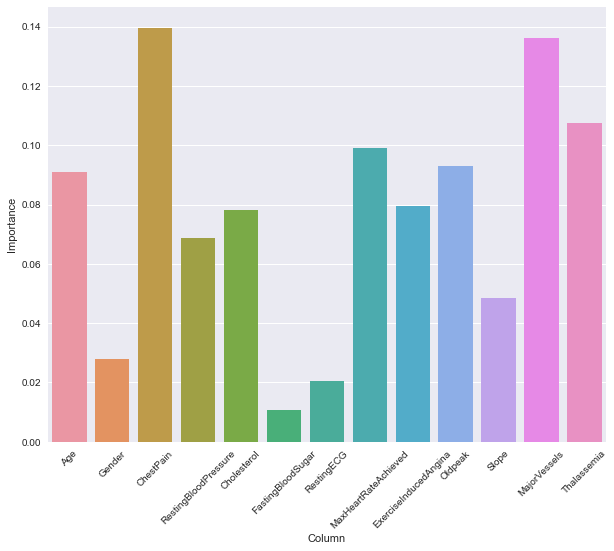

In [50]:
plt.figure(figsize=(10,8))
sns.barplot(x='Column', y='Importance', data=importance_table)
plt.xticks(rotation='45')
plt.show()

Kolom FastingBloodSugar mempunyai nilai importance yang sangat kecil. Apa yang akan terjadi jika kolom tersebut tidak dipakai ke dalam model dan dihapus?

In [51]:
x_dropped = df.drop(['FastingBloodSugar','Target'], axis=1)
y = df['Target'] 

In [52]:
x_dropped_train, x_dropped_test, y_train, y_test = train_test_split(
    x_dropped,
    y,
    stratify=y, 
    test_size=0.30 
)

In [53]:
model_dropped = rf.fit(x_dropped_train,y_train) 
y_pred_dropped = model_dropped.predict(x_dropped_test) 
print(classification_report(y_test,y_pred_dropped)) 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       150
           1       1.00      0.96      0.98       158

    accuracy                           0.98       308
   macro avg       0.98      0.98      0.98       308
weighted avg       0.98      0.98      0.98       308



Setelah kolom FastingBloodSugar tidak dipakai dan dihapus, performa model menjadi turun dan mendapatkan f1 score sebesar 0.98, yang tadinya 1.00.

## Conclusion  

Model terbaik untuk data set Heart Disease adalah **Random Forest**.  
Dikarenakan performa model sudah sangat tinggi, proses feature engineering dan hyperparameter tuning tidak dilakukan untuk menghindari penurunan performa model.

## Saving Best Model

In [55]:
# best_model = rf.fit(x_train,y_train)

# filename = 'Random Forest for Heart Disease Final.sav'

# pickle.dump(best_model, open(filename, 'wb'))

## *Reference*

https://archive.ics.uci.edu/ml/datasets/heart+disease  
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3576830/#R4  
https://www.timeofcare.com/typical-vs-atypical-chest-pain/#:~:text=Typical%20(classic)%20angina%20chest%20pain,of%20classic%20angina%20are%20present.  
https://gi.org/topics/non-cardiac-chest-pain/#:~:text=Non%2Dcardiac%20chest%20pain%20(NCCP,%2C%20squeezing%20or%20pressure%2Dlike.
https://en.wikipedia.org/wiki/Blood_pressure#:~:text=Normal%20resting%20blood%20pressure%2C%20in,%22120%2F80%20mmHg%22.  
https://www.ncbi.nlm.nih.gov/books/NBK279251/
https://medlineplus.gov/cholesterol.html#:~:text=Cholesterol%20is%20a%20waxy%2C%20fat,all%20the%20cholesterol%20it%20needs. 
https://medlineplus.gov/ldlthebadcholesterol.html 
https://my.clevelandclinic.org/health/articles/11920-cholesterol-numbers-what-do-they-mean   
https://www.merckmanuals.com/medical-calculators/RomhiltEstes.htm  (kriteria Estes)  
https://www.mayoclinic.org/diseases-conditions/left-ventricular-hypertrophy/symptoms-causes/syc-20374314#:~:text=Left%20ventricular%20hypertrophy%20is%20a,cause%20is%20high%20blood%20pressure.  
https://en.wikipedia.org/wiki/Fluoroscopy  
https://www.alodokter.com/ketahui-alasan-detak-jantung-cepat-dan-cara-mengatasinya